In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

## LOADING DATA

In [4]:
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# DATA CLEANING

### How many rows/columns?

In [5]:
df.shape

(8523, 12)

### Review Data Types

In [6]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

All columns appear to be assigned the appropriate data type. Further inspection will determine if any columns
will need to be converted.

## Duplicated Data

Checking for Duplicated Data

In [7]:
df.duplicated().sum()

0

There are no duplicated values.

In [8]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

The column Item_Fat_Content contains five unqiue values, but according to our data dictionary,
it should only contain two: Low-Fat and Regular.

In [9]:
# Reviewing value counts for Item_Fat_Content
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [10]:
# Replacing and Standardizing Inconsistent Values
df["Item_Fat_Content"] = df['Item_Fat_Content'].replace({'low fat':'Low Fat',
'reg':'Regular', 'LF': 'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Checking for missing values

In [11]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Identify % of missing data

In [12]:
df.isna().sum() / len(df) * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

## Missing Values:

  There are 1,463 missing values for Item_Weight (17%).

  There are 2,410 missing values for Outlet_size (28%).

  We will address the missing values in the preprocessing stage following the train/test split.

In [14]:
# Create a rename dictionary
rename_dict = {'Item_Weight':'Weight', 'Item_Fat_Content':'Fat_Content', 'Item_Visibility':'Visibility',
'Item_Type':'Type', 'Item_MRP': 'MRP', 'Outlet_Establishment_Year':'Establishment_Year', 'Outlet_Location_Type':
'Location_Type'}
rename_dict

{'Item_Weight': 'Weight',
 'Item_Fat_Content': 'Fat_Content',
 'Item_Visibility': 'Visibility',
 'Item_Type': 'Type',
 'Item_MRP': 'MRP',
 'Outlet_Establishment_Year': 'Establishment_Year',
 'Outlet_Location_Type': 'Location_Type'}

In [15]:
# Dictionary substitution using rename method
df = df.rename(rename_dict, axis=1)
df.head()

,Item_Identifier,Weight,Fat_Content,Visibility,Type,MRP,Outlet_Identifier,Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Item_Identifier     8523 non-null   object 
 1   Weight              7060 non-null   float64
 2   Fat_Content         8523 non-null   object 
 3   Visibility          8523 non-null   float64
 4   Type                8523 non-null   object 
 5   MRP                 8523 non-null   float64
 6   Outlet_Identifier   8523 non-null   object 
 7   Establishment_Year  8523 non-null   int64  
 8   Outlet_Size         6113 non-null   object 
 9   Location_Type       8523 non-null   object 
 10  Outlet_Type         8523 non-null   object 
 11  Item_Outlet_Sales   8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


SUMMARY STATISTICS FOR NUMERIC VALUES

The minimum value for visibility is 0, which is not possible. To address this, we will convert this value to null and impute in the preprocessing stage.

In [17]:
df.describe().round(2)

,Weight,Visibility,MRP,Establishment_Year,Item_Outlet_Sales
count,7060.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.64,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


In [18]:
# Create a filter to identify the rows where Visibility = 0.00
filter_zero_vis = df['Visibility'] == 0.00

In [19]:
# Change to a null value
df.loc[filter_zero_vis, 'Visibility']=np.nan

In [20]:
# Confirm change to null value
df['Visibility'].describe()

count    7997.000000
mean        0.070482
std         0.050308
min         0.003575
25%         0.031403
50%         0.057792
75%         0.098109
max         0.328391
Name: Visibility, dtype: float64

In [21]:
df['Visibility'].isna().sum()

526

In [22]:
# Saving the cleaned data to Google Drive
fpath_out = "/content/drive/MyDrive/CodingDojo/02-IntroML/Week08/Data/sales-predictioncore-cleaned-eda.csv"
df.to_csv(fpath_out, index=True)

In [23]:
# Loading and inspecting saved file
loaded = pd.read_csv(fpath_out)
loaded.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Item_Identifier     8523 non-null   object 
 1   Weight              7060 non-null   float64
 2   Fat_Content         8523 non-null   object 
 3   Visibility          7997 non-null   float64
 4   Type                8523 non-null   object 
 5   MRP                 8523 non-null   float64
 6   Outlet_Identifier   8523 non-null   object 
 7   Establishment_Year  8523 non-null   int64  
 8   Outlet_Size         6113 non-null   object 
 9   Location_Type       8523 non-null   object 
 10  Outlet_Type         8523 non-null   object 
 11  Item_Outlet_Sales   8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## PREPROCESSING

In [28]:
fpath = '/content/drive/MyDrive/CodingDojo/02-IntroML/Week08/Data/sales-predictioncore-cleaned-eda.csv'
df = pd.read_csv(fpath)

In [26]:
df.head()

,Item_Identifier,Weight,Fat_Content,Visibility,Type,MRP,Outlet_Identifier,Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,NaN,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [29]:
# Drop column Item_Identifier due to its high cardinality
df = df.drop(columns='Item_Identifier')

In [30]:
df.head()

,Unnamed: 0,Weight,Fat_Content,Visibility,Type,MRP,Outlet_Identifier,Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,3,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,4,8.93,Low Fat,NaN,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [31]:
# Drop Unnamed: 0 column
df = df.drop(columns='Unnamed: 0')

In [32]:
df.head()

,Weight,Fat_Content,Visibility,Type,MRP,Outlet_Identifier,Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,NaN,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [33]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [34]:
y = df['Item_Outlet_Sales']
X = df.drop(columns='Item_Outlet_Sales')

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Weight,Fat_Content,Visibility,Type,MRP,Outlet_Identifier,Establishment_Year,Outlet_Size,Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


In [41]:
location_types = { 'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3}

X_train['Location_Type'] = X_train['Location_Type'].replace(location_types)
X_test['Location_Type'] = X_test['Location_Type'].replace(location_types)

X_train['Location_Type'].value_counts(dropna=False)

3    2501
2    2069
1    1822
Name: Location_Type, dtype: int64

In [36]:
outlet_sizes = {'Small': 0, 'Medium': 1, 'High':2}

X_train['Outlet_Size'] = X_train['Outlet_Size'].replace(outlet_sizes)
X_test['Outlet_Size'] = X_test['Outlet_Size'].replace(outlet_sizes)

X_train['Outlet_Size'].value_counts(dropna=False)

1.0    2106
0.0    1802
NaN    1785
2.0     699
Name: Outlet_Size, dtype: int64

In [51]:
ord_cols = ['Outlet_Size','Location_Type']

impute_na_ord = SimpleImputer(strategy='most_frequent', fill_value='NA')
ord_encoder = OrdinalEncoder()
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_tuple = ('ordinal', ord_pipe, ord_cols)

In [66]:
ohe_cols = X_train.select_dtypes('object').columns
ohe_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop = 'first', sparse=False))
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

In [67]:
num_cols = X_train.select_dtypes("number").columns
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('numeric', num_pipe, num_cols)

In [68]:
preprocessor = ColumnTransformer([num_tuple, ohe_tuple, ord_tuple], verbose_feature_names_out=True)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Weight', 'Visibility', 'MRP', 'Establishment_Year', 'Outlet_Size',
       'Location_Type'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='const...
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['Fat_Content', 'Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size', 'Location_Type'])])

In [84]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_tf = pd.DataFrame(preprocessor.transform(X_train),
                          columns = feature_names, index = X_train.index)

X_test_tf = pd.DataFrame(preprocessor.transform(X_test),
                          columns = feature_names, index = X_test.index)
X_test_tf.head(3)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,numeric__Weight,numeric__Visibility,numeric__MRP,numeric__Establishment_Year,numeric__Outlet_Size,numeric__Location_Type,categorical__Fat_Content_Regular,categorical__Type_Breads,categorical__Type_Breakfast,categorical__Type_Canned,...,categorical__Outlet_Identifier_OUT027,categorical__Outlet_Identifier_OUT035,categorical__Outlet_Identifier_OUT045,categorical__Outlet_Identifier_OUT046,categorical__Outlet_Identifier_OUT049,categorical__Outlet_Type_Supermarket Type1,categorical__Outlet_Type_Supermarket Type2,categorical__Outlet_Type_Supermarket Type3,ordinal__Outlet_Size,ordinal__Location_Type
8077,0.58,-0.17,-0.12,1.10,0.29,-0.13,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29,-0.13
2391,1.19,-0.51,-0.20,-0.09,-1.38,-1.36,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,-1.38,-1.36
163,-1.30,0.02,-0.41,-0.09,-1.38,-1.36,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,-1.38,-1.36


In [85]:
reg = RandomForestRegressor()
reg.fit(X_train_tf,y_train)
evaluate_regression(reg, X_train_tf, y_train, X_test_tf,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 293.372
- MSE = 180,512.665
- RMSE = 424.868
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 828.757
- MSE = 1,407,251.442
- RMSE = 1,186.276
- R^2 = 0.544


In [86]:
feature_importance = pd.Series(reg.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

numeric__Weight               0.06
numeric__Visibility           0.10
numeric__MRP                  0.44
numeric__Establishment_Year   0.04
numeric__Outlet_Size          0.00
Name: Feature Importances, dtype: float64

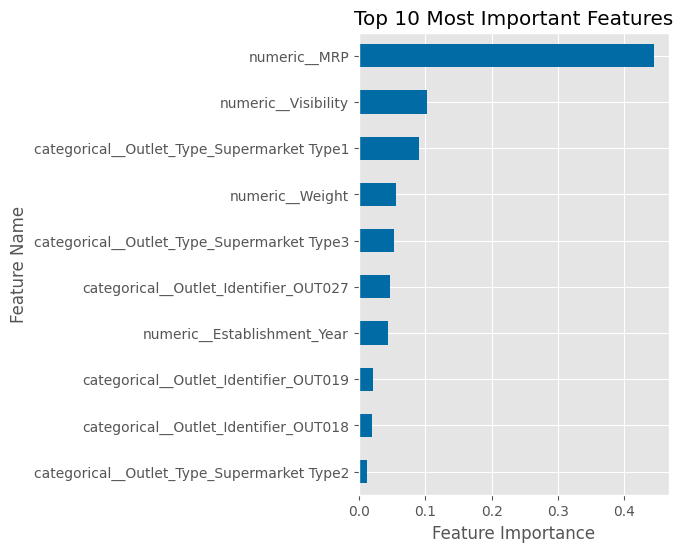

In [87]:
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

### TOP 5 MOST IMPORTANT FEATURES

  - MRP
  - Visibility
  - Outlet_Type (Supermarket Type 1)
  - Weight
  - Outlet_Type (Supermarket Type 3)

In [88]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_tf,y_train)
evaluate_regression(lin_reg, X_train_tf, y_train, X_test_tf,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 826.758
- MSE = 1,243,275.601
- RMSE = 1,115.023
- R^2 = 0.564

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 860.061
- MSE = 1,355,963.065
- RMSE = 1,164.458
- R^2 = 0.560


In [89]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()

numeric__Weight                                4.61
numeric__Visibility                           -9.94
numeric__MRP                                 965.85
numeric__Establishment_Year      858,106,876,739.33
numeric__Outlet_Size          43,226,990,761,782.16
Name: Coefficients, dtype: float64

In [91]:
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

numeric__Location_Type                       -163,093,078,618,084.44
ordinal__Outlet_Size                          -47,965,171,496,831.49
categorical__Outlet_Identifier_OUT035          -8,430,009,823,014.00
intercept                                      -4,016,158,049,873.79
categorical__Outlet_Identifier_OUT046          -1,723,453,856,649.52
categorical__Outlet_Identifier_OUT017            -856,463,577,788.96
categorical__Outlet_Identifier_OUT018            -643,733,903,544.82
numeric__Establishment_Year                       858,106,876,739.33
categorical__Outlet_Type_Supermarket Type3      1,022,437,573,995.75
categorical__Outlet_Identifier_OUT013           3,081,435,738,674.87
categorical__Outlet_Identifier_OUT019           5,430,111,149,433.35
categorical__Outlet_Type_Supermarket Type1      5,925,201,392,848.01
categorical__Outlet_Identifier_OUT049           5,952,456,023,305.36
numeric__Outlet_Size                           43,226,990,761,782.16
ordinal__Location_Type            

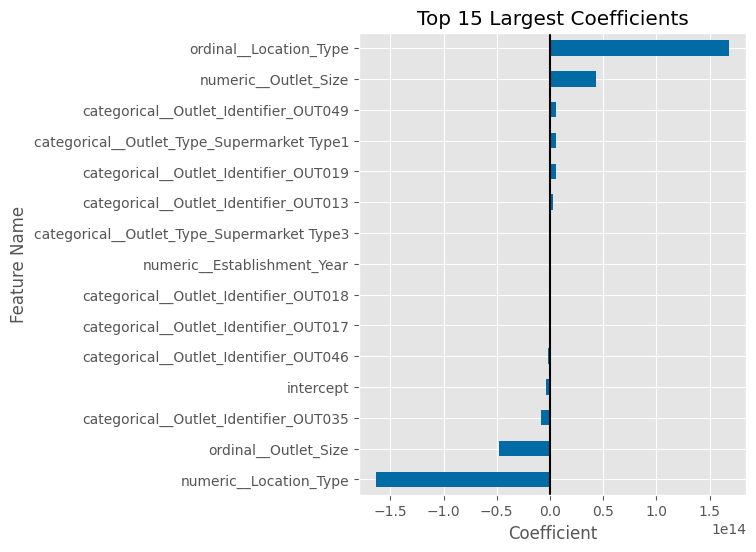

In [92]:
ax = coeffs_plot.sort_values().plot(kind='barh',figsize=(5,6))
ax.axvline(0,color='k');
ax.set(title = f"Top {top_n} Largest Coefficients",ylabel="Feature Name",
      xlabel='Coefficient');

## 3 LARGEST COEFFICIENTS

Location Type:

The type of location explains the difference in item outlet sales.

Outlet Size:

The outlet size is the second major driver in item outlet sales.

Outlet_Identifier

The outlet identifier is the third major driver in item outlet sales.